In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import kstest, jarque_bera, shapiro, ttest_1samp
from statsmodels.stats.diagnostic import acorr_ljungbox,het_arch, het_white
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (12,7)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = "--"
plt.rcParams['savefig.facecolor']='white'

# Przygotowanie danych

In [2]:
cocoa = pd.read_csv('Cocoa.csv')
milk = pd.read_csv('Milk.csv')
sugar = pd.read_csv('Sugar.csv')

In [3]:
cocoa['Date'] = pd.to_datetime(cocoa['Date'])
milk['Date'] = pd.to_datetime(milk['Date'])
sugar['Date'] = pd.to_datetime(sugar['Date'])

In [4]:
cocoa['Close/Last'] = cocoa['Close/Last'].astype(float)
milk['Close/Last'] = milk['Close/Last'].astype(float)
sugar['Close/Last'] = sugar['Close/Last'].astype(float)

In [5]:
pln_usd = pd.read_csv("PLNUSD=X.csv")

In [6]:
pln_usd = pln_usd[pln_usd["Close"].notnull()]

In [7]:
pln_usd.reset_index(inplace=True)

In [8]:
pln_usd["Date"] = pd.to_datetime(pln_usd["Date"])

In [9]:
dates = []
for i in range(len(pln_usd)):
    if pln_usd["Date"][i] not in list(cocoa["Date"]):
        dates.append(pln_usd["Date"][i])
    if pln_usd["Date"][i] not in list(milk["Date"]):
        dates.append(pln_usd["Date"][i])
    if pln_usd["Date"][i] not in list(sugar["Date"]):
        dates.append(pln_usd["Date"][i])

In [10]:
for i in range(len(cocoa)):
    if cocoa["Date"][i] not in list(pln_usd["Date"]):
        dates.append(cocoa["Date"][i])
    if sugar["Date"][i] not in list(pln_usd["Date"]):
        dates.append(sugar["Date"][i])

In [11]:
for i in range(len(milk)):
    if milk["Date"][i] not in list(pln_usd["Date"]):
        dates.append(milk["Date"][i])

In [12]:
dates = list(set(dates))

In [13]:
for i in range(len(dates)):
    pln_usd = pln_usd[pln_usd["Date"] !=  dates[i]]
    cocoa = cocoa[cocoa["Date"] !=  dates[i]]
    milk = milk[milk["Date"] !=  dates[i]]
    sugar = sugar[sugar["Date"] !=  dates[i]]

In [14]:
pln_usd = pln_usd[::-1]

In [15]:
pln_usd.reset_index(inplace=True)
cocoa.reset_index(inplace=True)
milk.reset_index(inplace=True)
sugar.reset_index(inplace=True)

Zamiana danych na stopy procentowe.

In [16]:
T = 1/252
cocoa_close = np.array([round((cocoa['Close/Last'][i] - cocoa['Close/Last'][i+1])/(cocoa['Close/Last'][i+1] * T),3) for i in range(len(cocoa)-1)])
milk_close = np.array([round((milk['Close/Last'][i] - milk['Close/Last'][i+1])/(milk['Close/Last'][i+1] * T), 3) for i in range(len(milk)-1)])
sugar_close = np.array([round((sugar['Close/Last'][i] - sugar['Close/Last'][i+1])/(sugar['Close/Last'][i+1] * T), 3) for i in range(len(sugar)-1)])
pln_usd_close = np.array([round((pln_usd['Close'][i] - pln_usd['Close'][i+1])/(pln_usd['Close'][i+1] * T), 3) for i in range(len(pln_usd)-1)])

In [17]:
cocoa_close /= -100
milk_close /= -100
sugar_close /= -100
pln_usd_close /= 100

# 1. Estymacja średnich, odchyleń standardowych i korelacji

In [18]:
mu_c = np.mean(cocoa_close)
sigma_c = np.std(cocoa_close)
print(mu_c, sigma_c)

mu_m = np.mean(milk_close)
sigma_m = np.std(milk_close)
print(mu_m, sigma_m)

mu_s = np.mean(sugar_close)
sigma_s = np.std(sugar_close)
print(mu_s, sigma_s)

-0.0011226437699680513 0.046895540026747284
-0.0017608067092651758 0.06315052203248535
-0.0007991214057507985 0.0481337056540928


In [19]:
n = len(cocoa_close)
C = cocoa_close.reshape(1,n)
M = milk_close.reshape(1,n)
S = sugar_close.reshape(1,n)
R = np.concatenate([C,M,S],axis=0)

In [20]:
corr = np.corrcoef(R)

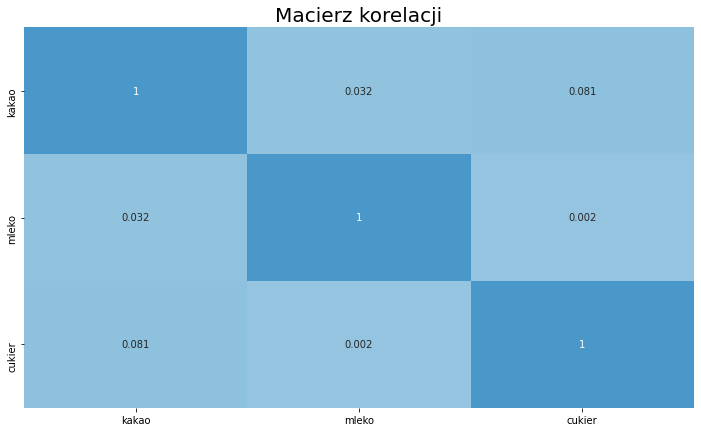

In [21]:
sns.heatmap(corr, annot=True, cmap="Blues", vmin=-2, vmax=3, cbar=False, xticklabels=["kakao", "mleko", "cukier"], yticklabels=["kakao", "mleko", "cukier"])
plt.title("Macierz korelacji", fontsize=20)
plt.show()

## a) stopa zwrotu i ryzyko portfela z rzeczywistymi wagami 

In [22]:
Rp = 0.5 * cocoa_close + 0.2 * milk_close + 0.3 * sugar_close

In [23]:
w = np.array([0.5, 0.2, 0.3])
print("Stopa zwrotu porfela: {}, ryzyko portfela: {}.".format(w[0]*mu_c + w[1]*mu_m + w[2]*mu_s, np.sqrt(np.dot(w.T, np.dot(np.cov(R), w)))))

Stopa zwrotu porfela: -0.0011532196485623003, ryzyko portfela: 0.03151053404357198.


## b) możliwe portfele dla różnych wag

In [24]:
param_list = np.arange(0,1.1,0.01)

In [25]:
combinations = []
for j in range(len(param_list)-1):
    for i in range(len(param_list)-1):
        vec = np.array([param_list[j], param_list[i], round(1-param_list[i]-param_list[j],2)])
        if (vec >= 0).sum() == vec.size and (vec <= 1).sum() == vec.size:
            combinations.append(vec)


In [26]:
expected_values = []
standard_deviations = []

for w in combinations:
    expected_values.append(w[0] * mu_c + w[1] * mu_m + w[2] * mu_s)
    standard_deviations.append(np.sqrt(np.dot(w.T, np.dot(np.cov(R), w))))

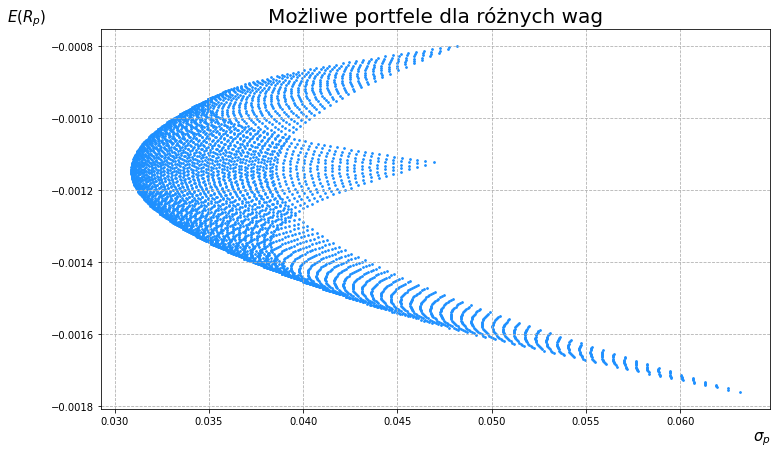

In [27]:
plt.scatter(standard_deviations, expected_values, color="dodgerblue", s=3)
plt.title("Możliwe portfele dla różnych wag", fontsize=20)
plt.xlabel(r"$\sigma_p$", fontsize=15, loc="right")
plt.ylabel(r"$E(R_p)$", fontsize=15, rotation=0, loc="top")
plt.show()

In [28]:
len(standard_deviations)

5151

## c) portfel o minimalnym ryzyku

In [29]:
standard_deviations.index(min(standard_deviations))

3221

In [30]:
expected_values[3221], standard_deviations[3221], combinations[3221]

(-0.001146482747603834, 0.030867148538808575, array([0.39, 0.23, 0.38]))

In [31]:
# Sprawdzamy czy zachodzą warunki - nie trzeba w sumie, whatever

print(corr[0,1] <= min(sigma_c/sigma_m, sigma_m/sigma_c))
print(corr[0,2] <= min(sigma_c/sigma_s, sigma_s/sigma_c))
print(corr[1,2] <= min(sigma_m/sigma_s, sigma_s/sigma_m))

True
True
True


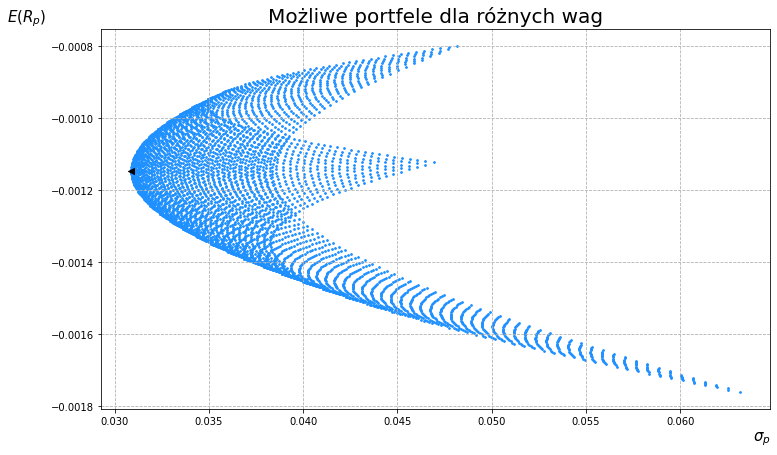

In [32]:
plt.scatter(standard_deviations, expected_values, color="dodgerblue", s=3)
plt.scatter(standard_deviations[3221], expected_values[3221], color='k', marker="<")
plt.title("Możliwe portfele dla różnych wag", fontsize=20)
plt.xlabel(r"$\sigma_p$", fontsize=15, loc="right")
plt.ylabel(r"$E(R_p)$", fontsize=15, rotation=0, loc="top")
plt.show()

## d) portfel o minimalnym ryzyku przy ustalonej stopie zwrotu

In [33]:
# ustalona stopa zwrotu
r = -0.00113

In [34]:
exp = np.array(expected_values).round(6)
ind = np.where(exp == r)[0].tolist()

In [35]:
standard_deviations.index(min([standard_deviations[i] for i in ind]))

3281

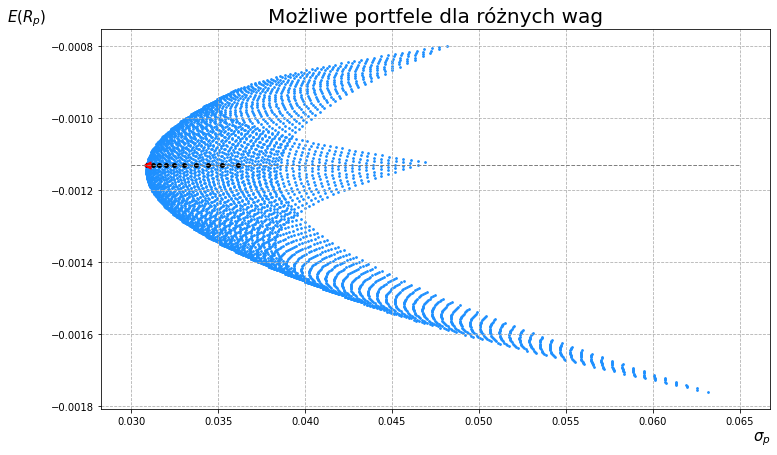

In [36]:
plt.scatter(standard_deviations, expected_values, color="dodgerblue", s=3)
plt.hlines(r, xmin=0.03, xmax=0.065, color='gray', linestyles="--", linewidth=1)
plt.scatter([standard_deviations[i] for i in ind], [expected_values[i] for i in ind], color='k', s=15)
plt.scatter(standard_deviations[3281], expected_values[3281], color='r', marker="<", s=50)
plt.title("Możliwe portfele dla różnych wag", fontsize=20)
plt.xlabel(r"$\sigma_p$", fontsize=15, loc="right")
plt.ylabel(r"$E(R_p)$", fontsize=15, rotation=0, loc="top")
plt.show()

In [37]:
expected_values[3281], standard_deviations[3281], combinations[3281]

(-0.0011304842651757188, 0.030896342832211772, array([0.4 , 0.21, 0.39]))

## e) portfel rynkowy

In [38]:
x = ((np.array(expected_values) - r)/np.array(standard_deviations)).tolist()

In [39]:
x.index(max(x))

0

In [101]:
#Tangens kąta
(expected_values[0] - r)/standard_deviations[0]

0.006871410030552513

In [40]:
expected_values[0], standard_deviations[0], combinations[0]

(-0.0007991214057507985, 0.0481529399028741, array([0., 0., 1.]))

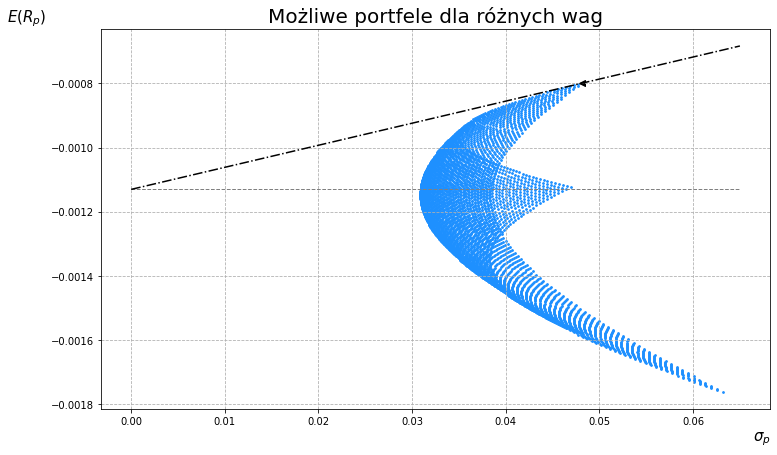

In [41]:
plt.scatter(standard_deviations, expected_values, color="dodgerblue", s=3)
plt.plot(np.arange(0,0.066,0.001), np.arange(0,0.066,0.001) * max(x) + r, color='k', linestyle="-.")
plt.hlines(r, xmin=0, xmax=0.065, color='gray', linestyles="--", linewidth=1)
plt.scatter(standard_deviations[0], expected_values[0], color='k', marker="<")
plt.title("Możliwe portfele dla różnych wag", fontsize=20)
plt.xlabel(r"$\sigma_p$", fontsize=15, loc="right")
plt.ylabel(r"$E(R_p)$", fontsize=15, rotation=0, loc="top")
plt.show()

# Model jednowskaźnikowy

## Kakao

In [42]:
y1 = cocoa_close
x1 = pln_usd_close

In [43]:
x1 = sm.add_constant(x1)

In [44]:
model1 = sm.GLS(y1, x1).fit()

In [45]:
print(model1.summary())

                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            GLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.294
Date:                Thu, 12 May 2022   Prob (F-statistic):              0.130
Time:                        11:34:27   Log-Likelihood:                 2055.5
No. Observations:                1252   AIC:                            -4107.
Df Residuals:                    1250   BIC:                            -4097.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.001     -0.859      0.3

In [46]:
alpha1 = model1.params[0]
beta1 = model1.params[1]

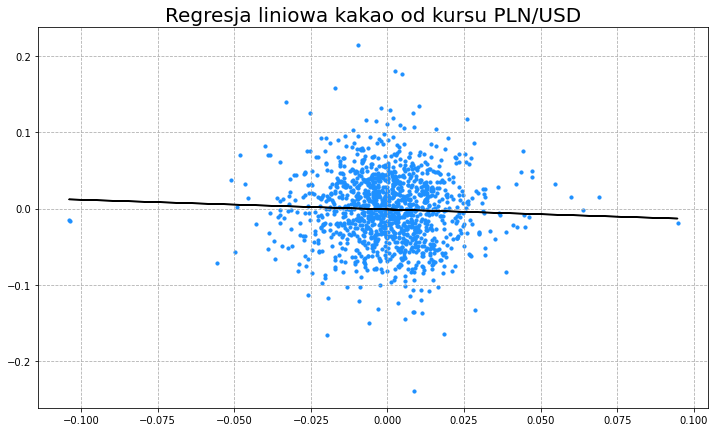

In [47]:
plt.scatter(pln_usd_close, cocoa_close, s=10, color="dodgerblue")
plt.plot(pln_usd_close, pln_usd_close*beta1 + alpha1, color='black')
plt.title("Regresja liniowa kakao od kursu PLN/USD", fontsize=20)
plt.show()

### Sprawdzenie założeń o residuach

In [48]:
epsilon1 = model1.resid

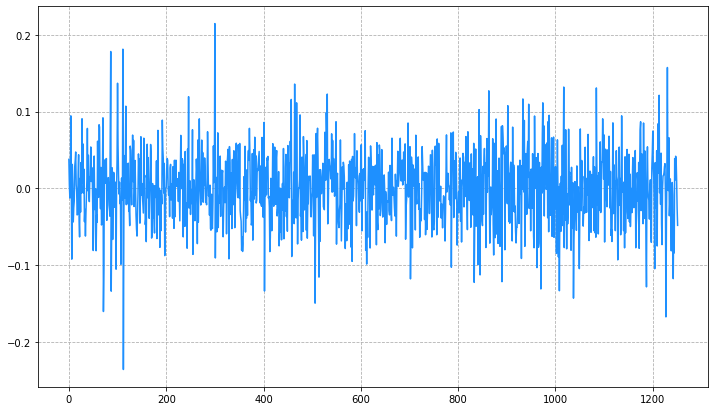

In [49]:
plt.plot(epsilon1, color="dodgerblue")
plt.show()

In [50]:
# Test na stałość wariancji

het_arch(epsilon1)

# Nie przechodzi

(24.64456137552533,
 0.00606153014708362,
 2.492078655971744,
 0.005836231307322963)

In [51]:
# Test na niezależność

acorr_ljungbox(epsilon1, lags=[30], return_df=True)

# Przechodzi

,lb_stat,lb_pvalue
30,43.400143,0.053999


In [52]:
#Testy na normalność

print("Test Kołmogorowa-Smirnowa: {}.".format(kstest( (epsilon1-epsilon1.mean())/epsilon1.std() , 'norm').pvalue))
print("Test Jarque-Bera: {}.".format(jarque_bera(epsilon1).pvalue))
print("Test Shapiro-Wilka: {}.".format(shapiro(epsilon1).pvalue))

Test Kołmogorowa-Smirnowa: 0.5331867797568621.
Test Jarque-Bera: 1.1102230246251565e-16.
Test Shapiro-Wilka: 3.024185616595787e-06.


In [53]:
#Test t-Studenta na to czy średnia jest równa 0

ttest_1samp(epsilon1, 0)

Ttest_1sampResult(statistic=-3.3471197240832264e-16, pvalue=0.9999999999999998)

In [97]:
#Założenie o braku korelacji ryzyka systemowego i specyficznego

np.cov(epsilon1, pln_usd_close)[0,1]

2.3573380568829512e-20

## Mleko

In [54]:
y2 = milk_close
x2 = pln_usd_close

In [55]:
x2 = sm.add_constant(x2)

In [56]:
model2 = sm.GLS(y2, x2).fit()

In [57]:
print(model2.summary())

                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            GLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.444
Date:                Thu, 12 May 2022   Prob (F-statistic):              0.118
Time:                        11:34:28   Log-Likelihood:                 1683.0
No. Observations:                1252   AIC:                            -3362.
Df Residuals:                    1250   BIC:                            -3352.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.002     -0.974      0.3

In [58]:
alpha2 = model2.params[0]
beta2 = model2.params[1]


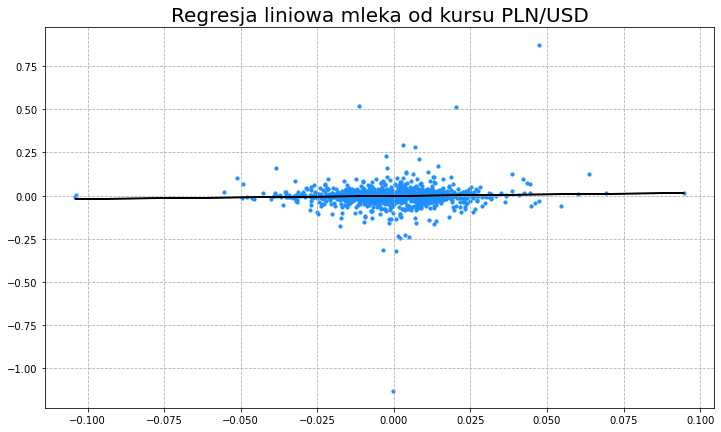

In [59]:
plt.scatter(pln_usd_close, milk_close, s=10, color="dodgerblue")
plt.plot(pln_usd_close, pln_usd_close*beta2 + alpha2, color='black')
plt.title("Regresja liniowa mleka od kursu PLN/USD", fontsize=20)
plt.show()

### Sprawdzenie założeń o residuach

In [60]:
epsilon2 = model2.resid

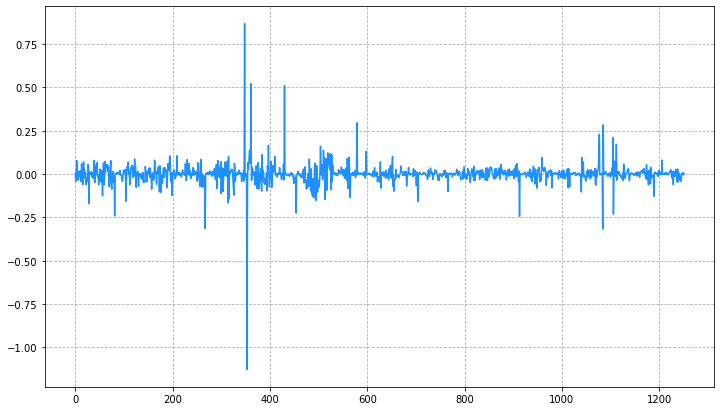

In [61]:
plt.plot(epsilon2, color="dodgerblue")
plt.show()

In [62]:
het_arch(epsilon2)

(279.5482701091264,
 3.242480597242152e-54,
 35.75492773475015,
 1.0983526707449678e-61)

In [63]:
#plot_acf(np.array(epsilon2)**2, lags=20, color="k", vlines_kwargs={"colors": "k"}, title="Wykres ACF residuów do kwadratu")
#plt.show()

In [64]:
#plot_acf(np.array(epsilon2), lags=20, color="k", vlines_kwargs={"colors": "k"}, title="Wykres ACF residuów")
#plt.show()

In [65]:
acorr_ljungbox(epsilon2, lags=[30], return_df=True)

,lb_stat,lb_pvalue
30,114.888065,7.238957e-12


In [66]:
print("Test Kołmogorowa-Smirnowa: {}.".format(kstest( (epsilon2-epsilon2.mean())/epsilon2.std() , 'norm').pvalue))
print("Test Jarque-Bera: {}.".format(jarque_bera(epsilon2).pvalue))
print("Test Shapiro-Wilka: {}.".format(shapiro(epsilon2).pvalue))

Test Kołmogorowa-Smirnowa: 3.3156554534357296e-38.
Test Jarque-Bera: 0.0.
Test Shapiro-Wilka: 0.0.


In [67]:
ttest_1samp(epsilon2, 0)

Ttest_1sampResult(statistic=4.2257194785164626e-16, pvalue=0.9999999999999997)

In [98]:
np.cov(epsilon2, pln_usd_close)[0,1]

-4.0560081272839015e-20

## Cukier

In [68]:
y3 = sugar_close
x3 = pln_usd_close

In [69]:
x3 = sm.add_constant(x3)

In [70]:
model3 = sm.GLS(y3, x3).fit()

In [71]:
print(model3.summary())

                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            GLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6736
Date:                Thu, 12 May 2022   Prob (F-statistic):              0.412
Time:                        11:34:30   Log-Likelihood:                 2022.1
No. Observations:                1252   AIC:                            -4040.
Df Residuals:                    1250   BIC:                            -4030.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.001     -0.594      0.5

In [72]:
alpha3 = model3.params[0]
beta3 = model3.params[1]

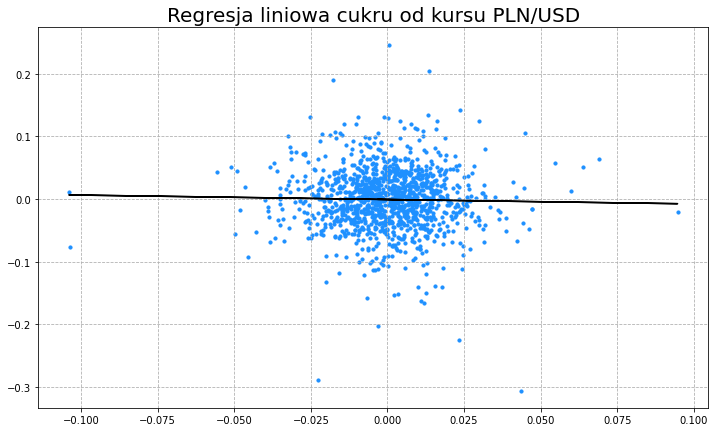

In [73]:
plt.scatter(pln_usd_close, sugar_close, s=10, color="dodgerblue")
plt.plot(pln_usd_close, pln_usd_close*beta3 + alpha3, color='black')
plt.title("Regresja liniowa cukru od kursu PLN/USD", fontsize=20)
plt.show()

### Sprawdzenie założeń o residuach

In [74]:
epsilon3 = model3.resid

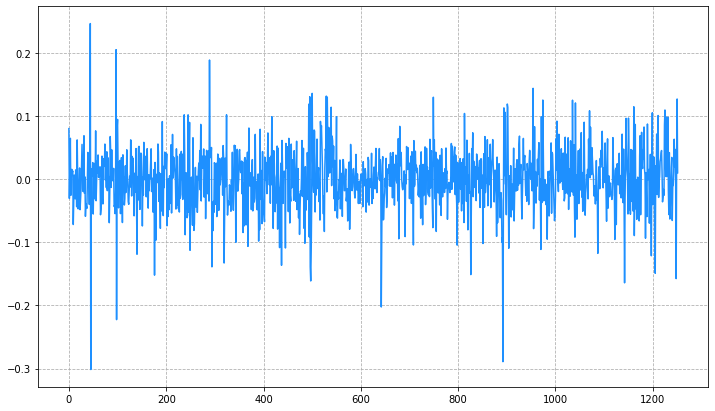

In [75]:
plt.plot(epsilon3, color="dodgerblue")
plt.show()

In [76]:
het_arch(epsilon3)

(65.51438738290219,
 3.2311649953134127e-10,
 6.855010380360725,
 1.7332332580683986e-10)

In [77]:
acorr_ljungbox(epsilon3, lags=[30], return_df=True)

,lb_stat,lb_pvalue
30,25.151948,0.717614


In [78]:
print("Test Kołmogorowa-Smirnowa: {}.".format(kstest( (epsilon3-epsilon3.mean())/epsilon3.std() , 'norm').pvalue))
print("Test Jarque-Bera: {}.".format(jarque_bera(epsilon3).pvalue))
print("Test Shapiro-Wilka: {}.".format(shapiro(epsilon3).pvalue))

Test Kołmogorowa-Smirnowa: 0.01424460388540884.
Test Jarque-Bera: 0.0.
Test Shapiro-Wilka: 8.27123702526884e-17.


In [79]:
ttest_1samp(epsilon3, 0)

Ttest_1sampResult(statistic=9.776727408728382e-16, pvalue=0.9999999999999992)

In [99]:
np.cov(epsilon3, pln_usd_close)[0,1]

2.6346719459280045e-20

## Portfel zmiennych ryzyka

In [80]:
alphas = [alpha1, alpha2, alpha3]
betas = [beta1, beta2, beta3]
var_epsilon = [np.var(epsilon1), np.var(epsilon2), np.var(epsilon3)]

## a) stopa zwrotu i ryzyko portfela z rzeczywistymi wagami 

In [81]:
w = np.array([0.5, 0.2, 0.3])
print("Stopa zwrotu porfela: {}, ryzyko portfela: {}.".format(sum(w*alphas) + sum(w*betas)*np.mean(pln_usd_close), sum(w*betas)**2*np.var(pln_usd_close) + sum(w**2*var_epsilon)))

Stopa zwrotu porfela: -0.0011532196485623007, ryzyko portfela: 0.0009170131328609112.


## b) możliwe portfele dla różnych wag

In [82]:
expected_values2 = []
standard_deviations2 = []

for w in combinations:
    expected_values2.append(sum(w*alphas) + sum(w*betas)*np.mean(pln_usd_close))
    standard_deviations2.append(sum(w*betas)**2*np.var(pln_usd_close) + sum(w**2*var_epsilon))

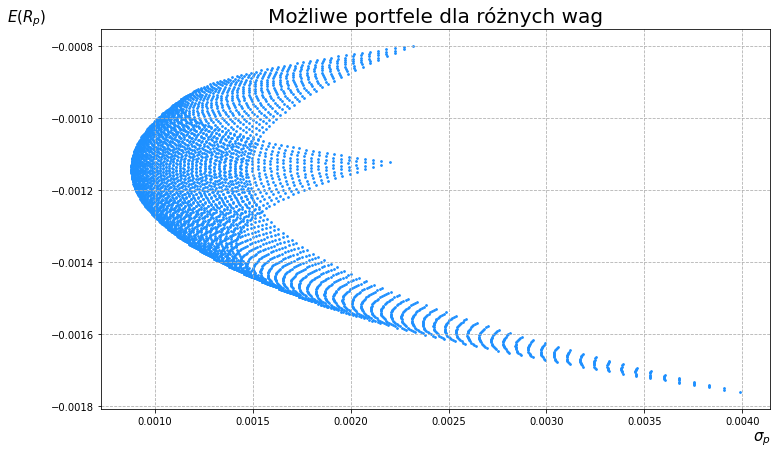

In [83]:
plt.scatter(standard_deviations2, expected_values2, color="dodgerblue", s=3)
plt.title("Możliwe portfele dla różnych wag", fontsize=20)
plt.xlabel(r"$\sigma_p$", fontsize=15, loc="right")
plt.ylabel(r"$E(R_p)$", fontsize=15, rotation=0, loc="top")
plt.show()

## c) portfel o minimalnym ryzyku

In [84]:
standard_deviations2.index(min(standard_deviations2))

3282

In [85]:
expected_values2[3282], standard_deviations2[3282], combinations[3282]

(-0.0011401011182108629, 0.0008786180980516712, array([0.4 , 0.22, 0.38]))

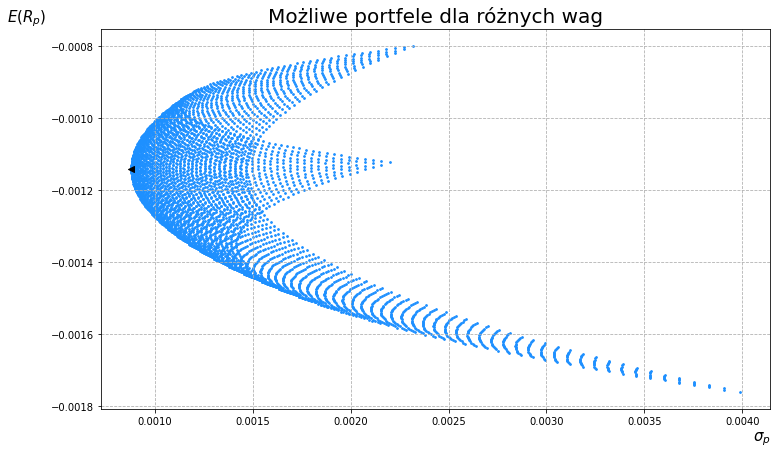

In [86]:
plt.scatter(standard_deviations2, expected_values2, color="dodgerblue", s=3)
plt.scatter(standard_deviations2[3282], expected_values2[3282], color='k', marker="<")
plt.title("Możliwe portfele dla różnych wag", fontsize=20)
plt.xlabel(r"$\sigma_p$", fontsize=15, loc="right")
plt.ylabel(r"$E(R_p)$", fontsize=15, rotation=0, loc="top")
plt.show()

## d) portfel o minimalnym ryzyku przy ustalonej stopie zwrotu

In [87]:
# ustalona stopa zwrotu
r = -0.00113

In [88]:
exp2 = np.array(expected_values2).round(6)
ind2 = np.where(exp2 == r)[0].tolist()

In [89]:
standard_deviations2.index(min([standard_deviations2[i] for i in ind2]))

3281

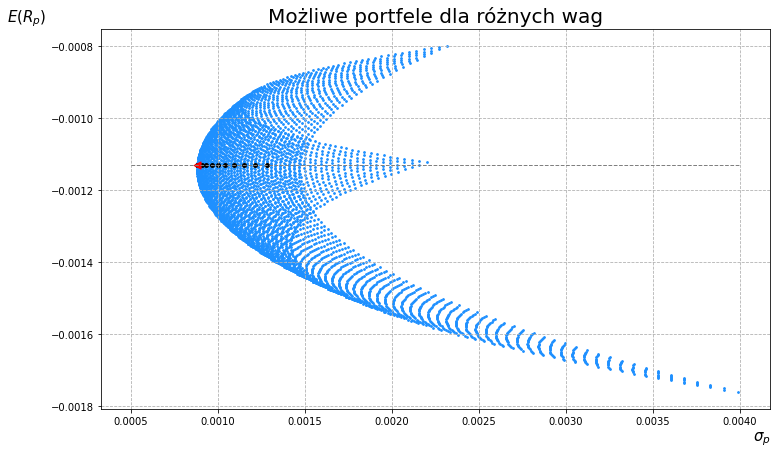

In [90]:
plt.scatter(standard_deviations2, expected_values2, color="dodgerblue", s=3)
plt.hlines(r, xmin=0.0005, xmax=0.004, color='gray', linestyles="--", linewidth=1)
plt.scatter([standard_deviations2[i] for i in ind2], [expected_values2[i] for i in ind2], color='k', s=15)
plt.scatter(standard_deviations2[3281], expected_values2[3281], color='r', marker="<", s=50)
plt.title("Możliwe portfele dla różnych wag", fontsize=20)
plt.xlabel(r"$\sigma_p$", fontsize=15, loc="right")
plt.ylabel(r"$E(R_p)$", fontsize=15, rotation=0, loc="top")
plt.show()

In [91]:
expected_values2[3281], standard_deviations2[3281], combinations[3281]

(-0.0011304842651757194, 0.0008793828514885287, array([0.4 , 0.21, 0.39]))

## e) portfel rynkowy

In [92]:
x2 = ((np.array(expected_values2) - r)/np.array(standard_deviations2)).tolist()

In [93]:
x2.index(max(x2))

2666

In [100]:
#Tangens kąta
(expected_values2[2666] - r)/standard_deviations2[2666]

0.1753036656944323

In [94]:
expected_values2[2666], standard_deviations2[2666], combinations[2666]

(-0.0008994133386581476, 0.0013153556169429026, array([0.31, 0.  , 0.69]))

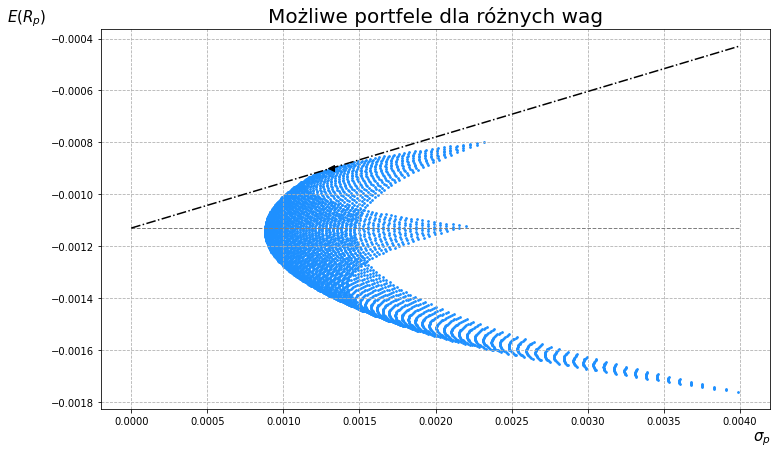

In [95]:
plt.scatter(standard_deviations2, expected_values2, color="dodgerblue", s=3)
plt.plot(np.arange(0,0.0041,0.0001), np.arange(0,0.0041,0.0001) * max(x2) + r, color='k', linestyle="-.")
plt.hlines(r, xmin=0, xmax=0.004, color='gray', linestyles="--", linewidth=1)
plt.scatter(standard_deviations2[2666], expected_values2[2666], color='k', marker="<")
plt.title("Możliwe portfele dla różnych wag", fontsize=20)
plt.xlabel(r"$\sigma_p$", fontsize=15, loc="right")
plt.ylabel(r"$E(R_p)$", fontsize=15, rotation=0, loc="top")
plt.show()